# Example for susi.SOMRegressor

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle

# --- for running the script without pip
import sys
sys.path.append("../")
# ---

import susi

## Read in data

**Dataset:** Felix M. Riese and Sina Keller, "Hyperspectral benchmark dataset on soil moisture", Dataset, Zenodo, 2018. [DOI:10.5281/zenodo.1227836](http://doi.org/10.5281/zenodo.1227836) and [GitHub](https://github.com/felixriese/hyperspectral-soilmoisture-dataset)

**Introducing paper:** Felix M. Riese and Sina Keller, “Introducing a Framework of Self-Organizing Maps for Regression of Soil Moisture with Hyperspectral Data,” in IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium, Valencia, Spain, 2018, pp. 6151-6154. [DOI:10.1109/IGARSS.2018.8517812](https://doi.org/10.1109/IGARSS.2018.8517812)

In [2]:
df = pd.read_csv(("https://raw.githubusercontent.com/felixriese/"
                  "hyperspectral-soilmoisture-dataset/master/soilmoisture_dataset.csv"))

In [3]:
# get hyperspectral bands:
hypbands = []
for col in df.columns:
    try:
        int(col)
    except Exception:
        continue
    hypbands.append(col)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df[hypbands], df["soil_moisture"],
    test_size=0.5, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 125) (340, 125) (339,) (340,)


## Regression

In [4]:
som = susi.SOMRegressor(
    n_rows=35,
    n_columns=35,
    n_iter_unsupervised=2500,
    n_iter_supervised=2500,
    neighborhood_mode_unsupervised="linear",
    neighborhood_mode_supervised="linear",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    learning_rate_start=0.5,
    learning_rate_end=0.05,
    # do_class_weighting=True,
    random_state=None,
    n_jobs=1)

In [5]:
# NBVAL_IGNORE_OUTPUT
som.fit(X_train, y_train)

SOMRegressor(distance_metric='euclidean', init_mode_supervised='random',
             init_mode_unsupervised='random', learn_mode_supervised='min',
             learn_mode_unsupervised='min', learning_rate_end=0.05,
             learning_rate_start=0.5, missing_label_placeholder=None,
             n_columns=35, n_iter_supervised=2500, n_iter_unsupervised=2500,
             n_jobs=1, n_rows=35, nbh_dist_weight_mode='pseudo-gaussian',
             neighborhood_mode_supervised='linear',
             neighborhood_mode_unsupervised='linear', random_state=None,
             train_mode_supervised='online', train_mode_unsupervised='online',
             verbose=0)

In [6]:
y_pred = som.predict(X_test)
y_pred_train = som.predict(X_train)

In [7]:
# NBVAL_IGNORE_OUTPUT

print("Train: {0:.1f} %".format(r2_score(y_train, y_pred_train)*100))
print("Test: {0:.1f} %".format(r2_score(y_test, y_pred)*100))

Train: 90.0 %
Test: 90.0 %


## Plots

### Plot estimation map

In [8]:
estimation_map = np.squeeze(som.get_estimation_map())

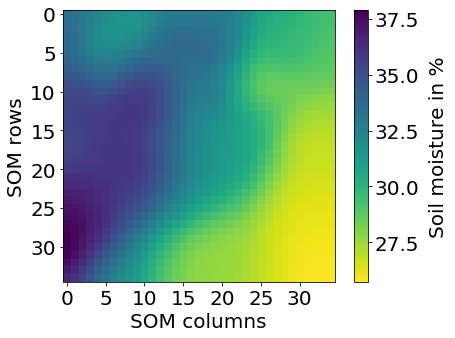

In [9]:
def plot_estimation_map(estimation_map, fontsize=20):
    plt.figure(figsize=(7,5))
    plt.imshow(estimation_map, cmap="viridis_r")
    plt.xlabel("SOM columns", fontsize=fontsize)
    plt.ylabel("SOM rows", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.set_ylabel('Soil moisture in %', fontsize=fontsize, labelpad=10)
    for label in cbar.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    plt.grid(b=False)

plot_estimation_map(estimation_map)

### Plot SOM histogram

In [10]:
def plot_som_histogram(bmu_list, n_rows, n_columns, fontsize=22):
    """Plot 2D Histogram of SOM.

    Plot 2D Histogram with one bin for each SOM node. The content of one
    bin is the number of datapoints matched to the specific node.

    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # colormap
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

    #bounds = np.linspace(0, 5, 6)
    bounds = np.arange(0.,6.,1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    ax2 = fig.add_axes([0.96, 0.12, 0.03, 0.76])
    cbar = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', extend="max")
    cbar.ax.set_ylabel('Number of datapoints', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

    counts, xedges, yedges, Image = ax.hist2d(
        [x[0] for x in bmu_list], [x[1] for x in bmu_list],
        bins=[n_rows, n_columns], cmin=1, cmap=cmap, norm=norm)

    #print(np.nanmax(counts))
    
    for label in cbar.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    # plt.xlim(xmin=0, xmax=self.NColumns)
    # plt.ylim(ymin=0, ymax=self.NRows)
    ax.set_xlabel("SOM columns", fontsize=fontsize)
    ax.set_ylabel("SOM rows", fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    # to be compatible with plt.imshow:
    ax.invert_yaxis()

    plt.grid(b=False)

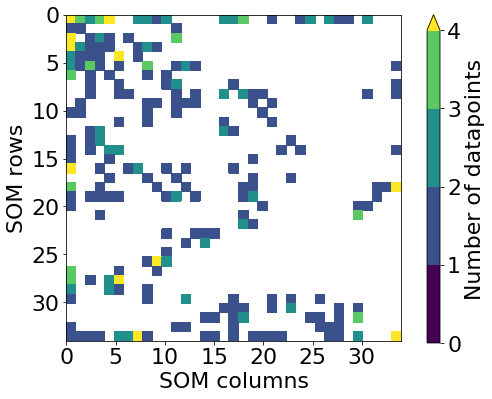

In [11]:
bmu_list = som.get_bmus(X_train.values, som.unsuper_som_)
plot_som_histogram(bmu_list, 35, 35)

### Plot u-matrix

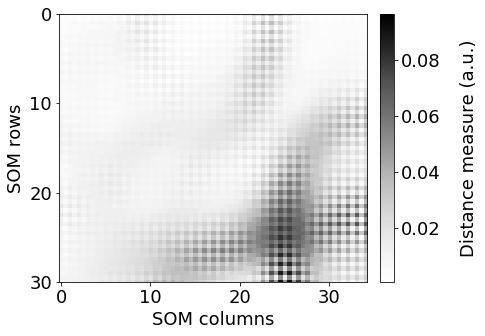

In [12]:
def plot_umatrix(u_matrix, n_rows, n_colums, title="", fontsize=18):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(u_matrix.squeeze(), cmap="Greys")
    plt.xticks(np.arange(0, n_colums*2+1, 20), np.arange(0, n_colums+1, 10))
    plt.yticks(np.arange(0, n_rows*2+1, 20), np.arange(0, n_rows+1, 10))

    # ticks and labels
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    ax.set_ylabel("SOM rows", fontsize=fontsize)
    ax.set_xlabel("SOM columns", fontsize=fontsize)

    # colorbar
    cbar = plt.colorbar(ax=ax, fraction=0.04, pad=0.04)  # fraction=0.046, pad=0.04
    cbar.ax.set_ylabel('Distance measure (a.u.)', rotation=90, fontsize=fontsize, labelpad=20)
    cbar.ax.tick_params(labelsize=fontsize)

u_matrix = som.get_u_matrix(mode="mean")
plot_umatrix(u_matrix, som.n_rows, som.n_columns)